In [77]:
from sklearn.manifold import Isomap
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import pairwise_distances, f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis


### GET ISOMAP FEATURES

In [2]:
sulci_distance_matrix = np.load('.././sulci_distance_matrix.npy')
sulci_reg_keys = np.load('.././sulci_reg_keys.npy')
np.shape(sulci_distance_matrix)

(572, 572)

In [5]:
ismap = Isomap(n_components=17, n_neighbors=14, n_jobs=-1)
sdm_transformed = ismap.fit_transform(sulci_distance_matrix)
print(sdm_transformed.shape)

(572, 17)


In [35]:
sulci_meta_str = [''.join(i[0].split('-')[:2]) for i in sulci_reg_keys]
subj_id = [i.split('_')[1] for i in sulci_meta_str]
subj_id = [x[:3] + '-' + x[3:] for x in subj_id]
side = [i.split('_')[0] for i in sulci_meta_str]

isomap_features = pd.DataFrame(sdm_transformed, columns=[f'isomap_{i}' for i in range(sdm_transformed.shape[1])])
isomap_features['subject_id'] = subj_id
isomap_features['side'] = side

isomap_features.head()

,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,isomap_8,isomap_9,isomap_10,isomap_11,isomap_12,isomap_13,isomap_14,isomap_15,isomap_16,subject_id,side
0,9.688326,-0.953670,-0.539174,-1.875211,-1.513877,0.044964,3.342995,-1.087683,-1.583092,-1.259045,1.994612,-0.614083,3.568669,-2.927934,-0.422573,1.461781,3.121010,sub-via003,left
1,14.372313,-2.251952,-3.152609,-0.080369,-5.992478,-0.792929,3.719239,-4.538002,-4.452302,1.816918,-0.960385,2.932196,-1.862068,-0.675507,-0.875355,0.245438,-3.009046,sub-via003,right
2,1.107278,-0.755399,-3.654512,-5.042098,-1.537551,-2.256313,6.692906,3.997100,-0.590491,-3.392920,0.223568,-3.420061,1.949864,3.084412,-3.318330,-0.377937,2.244742,sub-via004,left
3,6.269484,-1.159266,-2.753461,-0.480566,-4.779552,0.657374,5.456644,0.893196,-3.477424,-2.391934,2.810426,2.628400,3.298249,-1.955650,0.422064,0.155804,2.440332,sub-via004,right
4,-0.189985,-7.977296,4.868147,3.230779,-3.123908,-4.113416,-1.843032,5.329172,-5.001592,-2.208233,2.231607,-2.519707,0.988928,-2.047101,-1.121655,-0.172652,0.853392,sub-via005,left


### LOAD EDA FEATURES

In [36]:
# via11_scQA = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/QA_centralSulcus_lkj.xlsx')[['subjects', 'sites', 'vis_QA', 'editted']]
# via11_scQA = via11_scQA[~via11_scQA.subjects.isna()]
# via11_scQA = via11_scQA.set_index('subjects')

# via11_demo = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/VIA11_fmriflanker_info_database_2021jan25.xlsx')
# via11_demo = via11_demo[via11_demo.mp2rage_exists == 1].drop(columns=['in_via11', 'stormdb'])
# via11_demo['subjects'] = [f'sub-via{x:03d}' for x in via11_demo.via_id]
# via11_demo = via11_demo[~via11_demo.subjects.isna()]
# via11_demo = via11_demo[via11_demo.subjects.isin(via11_scQA.index.values)]
# via11_demo = via11_demo.set_index('subjects')

# for subject in via11_demo.index.values:
#     # via11_demo.loc[subject, 'site'] = via11_scQA.loc[subject, 'sites']
#     via11_demo.loc[subject, 'vis_QA'] = via11_scQA.loc[subject, 'vis_QA']
#     via11_demo.loc[subject, 'editted'] = via11_scQA.loc[subject, 'editted']
    
# via11_demo

In [37]:
# cs_feat = pd.read_pickle('../data/bvisa_subject_features.pkl')

In [38]:
# def select_morphofeatures(df:pd.DataFrame,
#                           features:list[str] = ['label',
#                                                 'side',
#                                                 'surface_talairach',
#                                                 'maxdepth_talairach',
#                                                 'meandepth_talairach',
#                                                 'hull_junction_length_talairach',
#                                                 'GM_thickness', 'opening'], 
#                           sulci: list[str] = ['S.C.'],
#                           side: str = 'r'):
#     """_summary_

#     Args:
#         df (pd.DataFrame): DataFrame with morphological features of a subject
#         features (list[str], optional): List of features to use. Defaults to ['label', 'side', 'surface_talairach', 'maxdepth_talairach', 'meandepth_talairach'].
#         sulci (list[str], optional): List of sulci to use. Defaults to ['S.C.'].
#         side (str, optional): Which sides of sulci to use as features.
#             Could be 'l' or 'r' to extract features only from left or right
#             sulci or 'both' to extract features from both. Defaults to 'r'.

#     Returns:
#         np.ndarray: 1D array of features
#         np.ndarray: 1D array of feature names
#     """
#     # filter by selected sulci
#     features = df[df.label.isin(sulci)][features]
#     if len(sulci) == 1:
#         features = features.drop(columns=['label'])
#     else:
#         raise NotImplementedError('Only one sulcus is supported for now')
    
#     # get feature names
#     if side == 'l' or side =='r':
#         feature_names = [f'{side}_{c}' for c in features.columns.values]
#     else:
#         feature_names = [f'{s}_{c}' for s in ['l', 'r']  for c in features.columns.values if c != 'side']
    
#     # transform features into an array
#     if side == 'l':
#         features = features[features.side == 'left'].drop(columns=['side'])
#     elif side == 'r':
#         features = features[features.side == 'right'].drop(columns=['side'])
#     elif side == 'both':
#         features = features.drop(columns=['side'])
#     else:
#         raise ValueError('side should be either "l", "r" or "both"')
#     features = features.values.flatten()
    
    
#     return features, feature_names
    

In [39]:
# medial_axis_L_depth_matrix = np.stack([cs_feat[x]['medial_axis_L']['depth'].values for x in cs_feat.keys()])
# medial_axis_R_depth_matrix = np.stack([cs_feat[x]['medial_axis_R']['depth'].values for x in cs_feat.keys()])
# depth_profile_L_depth_matrix = np.stack([cs_feat[x]['depth_profile_L']['depth'].values for x in cs_feat.keys()])
# depth_profile_R_depth_matrix = np.stack([cs_feat[x]['depth_profile_R']['depth'].values for x in cs_feat.keys()])

# medial_axis_L_profile_matrix = np.stack([cs_feat[x]['medial_axis_L']['profile'].values for x in cs_feat.keys()])
# medial_axis_R_profile_matrix = np.stack([cs_feat[x]['medial_axis_R']['profile'].values for x in cs_feat.keys()])
# depth_profile_L_profile_matrix = np.stack([cs_feat[x]['depth_profile_L']['profile'].values for x in cs_feat.keys()])
# depth_profile_R_profile_matrix = np.stack([cs_feat[x]['depth_profile_R']['profile'].values for x in cs_feat.keys()])


In [40]:
# FA_number_components = 3

# fa = FactorAnalysis(n_components=FA_number_components) # OR CHANGE TO PCA
# medial_axis_L_depth_fa = fa.fit_transform(medial_axis_L_depth_matrix)
# medial_axis_R_depth_fa = fa.fit_transform(medial_axis_R_depth_matrix)
# depth_profile_L_depth_fa = fa.fit_transform(depth_profile_L_depth_matrix)
# depth_profile_R_depth_fa = fa.fit_transform(depth_profile_R_depth_matrix)
# medial_axis_L_profile_fa = fa.fit_transform(medial_axis_L_profile_matrix)
# medial_axis_R_profile_fa = fa.fit_transform(medial_axis_R_profile_matrix)
# depth_profile_L_profile_fa = fa.fit_transform(depth_profile_L_profile_matrix)
# depth_profile_R_profile_fa = fa.fit_transform(depth_profile_R_profile_matrix)


In [41]:
# morph_feat = pd.DataFrame(np.stack([select_morphofeatures(cs_feat[x]['morphology'], side='both')[0] for x in cs_feat.keys()]),
#                           columns=select_morphofeatures(cs_feat['sub-via003']['morphology'], side='both')[1], index=[x for x in cs_feat.keys()])

# profile_feat = {'L_medial_axis_depth':medial_axis_L_depth_fa,
#                 'R_medial_axis_depth':medial_axis_R_depth_fa,
#                 'L_depth_profile_depth':depth_profile_L_depth_fa,
#                 'R_depth_profile_depth':depth_profile_R_depth_fa,
#                 'L_medial_axis_profile':medial_axis_L_profile_fa,
#                 'R_medial_axis_profile':medial_axis_R_profile_fa,
#                 'L_depth_profile_profile':depth_profile_L_profile_fa,
#                 'R_depth_profile_profile':depth_profile_R_profile_fa,
#             }

# for f in profile_feat.keys():
#     for fnum in range(FA_number_components):
#         morph_feat[f'{f}_{fnum}'] = profile_feat[f][:, fnum]

# morph_feat

In [42]:
# TARGET_FEAT = ['handedness', 'group', 'cbcl_total', 'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis']
# target_df = via11_demo[TARGET_FEAT]
# target_df

In [53]:
# eda_df = target_df.join(morph_feat).join(via11_demo[['mri_age', 'sex']])
# eda_df.to_pickle('../data/eda_df.pkl')

# Analyze ISOMAP Features

In [54]:
eda_df = pd.read_pickle('../data/eda_df.pkl')

Checking if we need to correct for age/sex

Test if the coordinates for any Isomap dimension correlated with `mri_age`, `sex` at acquisition, independently for each age-group but together for left and right sulci.

The resultant correlations (going up to 0.30 for dimension 1 at 30w PMA) confirmed the importance of correcting the dimension coordinates for PMA at MRI acquisition in each group, before conducting further analyses.

In [74]:
for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = isomap_features[isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in isomap_features.columns[:-2]:
        if abs(grp_df[id].corr(grp_df.mri_age)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with age in group {g}: {grp_df[id].corr(grp_df.mri_age)}')
        if abs(grp_df[id].corr(grp_df.sex)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with sex in group {g}: {grp_df[id].corr(grp_df.sex)}')

Correlation of ISOMAP feature isomap_5 with sex in group 3.0: -0.1272873516788543
Correlation of ISOMAP feature isomap_8 with sex in group 3.0: -0.17913057426703904
Correlation of ISOMAP feature isomap_11 with sex in group 3.0: -0.12732020422533022
Correlation of ISOMAP feature isomap_13 with sex in group 3.0: -0.10122081686511812
Correlation of ISOMAP feature isomap_16 with sex in group 3.0: -0.10748845932996756
Correlation of ISOMAP feature isomap_1 with age in group 2.0: 0.14028350243856713
Correlation of ISOMAP feature isomap_2 with age in group 2.0: -0.11435594762672059
Correlation of ISOMAP feature isomap_3 with sex in group 2.0: 0.11163840156876087
Correlation of ISOMAP feature isomap_6 with sex in group 2.0: -0.16516314930823925
Correlation of ISOMAP feature isomap_7 with age in group 2.0: -0.13062277207295503
Correlation of ISOMAP feature isomap_8 with age in group 2.0: -0.18412701089524636
Correlation of ISOMAP feature isomap_11 with age in group 2.0: -0.11887529821095778
Cor

### Perform correction of ISOMAP features for age at MRI acquisition and sex

Instead of using the raw Isomap coordinates for each dimension as the input for the subsequent analyses, we used their residuals after correction for age (that we centered on the age-group mean position on the Isomap in order to restore the information about inter-age-group positioning). The residuals were computed by solving, independently for each age-group, the linear model:
```
raw_isomap = alpha*age + beta + corrected_isompa
raw_isomap - corrected_ismap = alpha*age + beta

In [166]:
corrected_isomap_features = isomap_features.copy(deep=True)

for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = corrected_isomap_features[corrected_isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in corrected_isomap_features.columns[:-2]:
        lr = LinearRegression(fit_intercept=True)
        X = grp_df.mri_age.values.reshape(-1, 1)
        y = grp_df[id].values.reshape(-1, 1)
        lr.fit(X, y)
        y_pred = lr.predict(X)
        residuals = grp_df[id].values - y_pred.reshape(-1)
        corrected_isomap_features.loc[corrected_isomap_features.subject_id.isin(grp_subj), id] = residuals + corrected_isomap_features.loc[corrected_isomap_features.subject_id.isin(grp_subj), id].mean()

In [167]:
for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = corrected_isomap_features[corrected_isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in isomap_features.columns[:-2]:
        if abs(grp_df[id].corr(grp_df.mri_age)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with age in group {g}: {grp_df[id].corr(grp_df.mri_age)}')
        # if abs(gr'Correlation of ISOMAP feature {id} with sex in group {g}: {grp_df[id].corr(grp_df.sex)}')p_df[id].corr(grp_df.sex)) > 0.1:
        #     print(f

Sex is balanced between groups

In [168]:
for g in via11_demo.group.unique():
    males = via11_demo[via11_demo.group == g].sex.value_counts()
    print(f'Group {g}: \n{males/males.values.sum()}')

Group 3.0: 
0.0    0.5
1.0    0.5
Name: sex, dtype: float64
Group 2.0: 
1.0    0.508929
0.0    0.491071
Name: sex, dtype: float64
Group 1.0: 
1.0    0.536232
0.0    0.463768
Name: sex, dtype: float64


For each Isomap dimension, we investigated the relative positioning of the subgroups using two tests: a Wilcoxon signed-rank test to investigate whether the two age- or hemisphere-groups differed in positioning on a specific dimension (suggesting a difference in the shape of the sulci throughout development or between hemispheres), and a Spearman correlation to assess whether the two age- or hemisphere-groups showed correlated shape features (suggesting early and stable shape patterns throughout development or between the hemispheres). We conducted these tests between ages for each hemisphere (L30 vs L40, R30 vs R40), and between hemispheres at each age (L30 vs R30, L40 vs R40). Applying a correction for multiple comparisons with the Bonferroni approach would have led to a statistical threshold at 0.00125 for an alpha level at 0.05 because of the 40 tests performed (4 age-and-hemisphere-specific tests x 10 dimensions tested). However, as the Bonferroni method may be considered as too restrictive, we focused on results with p-values under the threshold computed for each age-and-hemisphere-specific test, thus only compensating for the number of dimensions, resulting in a statistical threshold at 0.005. Only the results with p-values below or in the same range as this corrected threshold are described in the Results section. The whole test results are available in Sup. Info., Table 3 for Wilcoxon signed rank tests and Table 4 for Spearman correlations.



In [190]:
eda_df_sided = []
sided_morph_feat = ['l_surface_talairach', 'l_maxdepth_talairach',
       'l_meandepth_talairach', 'l_hull_junction_length_talairach',
       'l_GM_thickness', 'l_opening', 'r_surface_talairach',
       'r_maxdepth_talairach', 'r_meandepth_talairach',
       'r_hull_junction_length_talairach', 'r_GM_thickness', 'r_opening',
       'L_medial_axis_depth_0', 'L_medial_axis_depth_1',
       'L_medial_axis_depth_2', 'R_medial_axis_depth_0',
       'R_medial_axis_depth_1', 'R_medial_axis_depth_2',
       'L_depth_profile_depth_0', 'L_depth_profile_depth_1',
       'L_depth_profile_depth_2', 'R_depth_profile_depth_0',
       'R_depth_profile_depth_1', 'R_depth_profile_depth_2',
       'L_medial_axis_profile_0', 'L_medial_axis_profile_1',
       'L_medial_axis_profile_2', 'R_medial_axis_profile_0',
       'R_medial_axis_profile_1', 'R_medial_axis_profile_2',
       'L_depth_profile_profile_0', 'L_depth_profile_profile_1',
       'L_depth_profile_profile_2', 'R_depth_profile_profile_0',
       'R_depth_profile_profile_1', 'R_depth_profile_profile_2']
not_sided_morh_feat = ['handedness', 'group', 'cbcl_total',
                       'cbcl_external', 'cbcl_internal',
                       'cgas', 'any_diagnosis']
for i, row in eda_df.iterrows():
    lsulc = {k:v for k,v in row.items() if k in not_sided_morh_feat}
    rsulc = {k:v for k,v in row.items() if k in not_sided_morh_feat}
    lsulc['side'] = 'left'
    rsulc['side'] = 'right'
    lsulc['subject_id'] = i
    rsulc['subject_id'] = i
    for k, v in row.items():
       if k in sided_morph_feat:
           if k[:2].lower() == 'l_':
              lsulc[k[2:]] = v
           if k[:2].lower() == 'r_':
              rsulc[k[2:]] = v
    eda_df_sided.append(lsulc)
    eda_df_sided.append(rsulc)

In [191]:
eda_df_sided = pd.DataFrame(eda_df_sided)
# merge on both side and subject_id
all_feat_df = pd.merge(corrected_isomap_features, eda_df_sided,
                       on=['subject_id', 'side'],
                       how='inner')

In [193]:
corr = all_feat_df.drop(columns=['subject_id', 'side']).corr(numeric_only=False)
corr.style.background_gradient(cmap='coolwarm').set_precision(3)
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps
# plt.show()

/tmp/ipykernel_3471042/2432263808.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,isomap_8,isomap_9,isomap_10,isomap_11,isomap_12,isomap_13,isomap_14,isomap_15,isomap_16,handedness,group,cbcl_total,cbcl_external,cbcl_internal,cgas,any_diagnosis,surface_talairach,maxdepth_talairach,meandepth_talairach,hull_junction_length_talairach,GM_thickness,opening,medial_axis_depth_0,medial_axis_depth_1,medial_axis_depth_2,depth_profile_depth_0,depth_profile_depth_1,depth_profile_depth_2,medial_axis_profile_0,medial_axis_profile_1,medial_axis_profile_2,depth_profile_profile_0,depth_profile_profile_1,depth_profile_profile_2
isomap_0,1.000,0.001,-0.008,-0.004,-0.002,0.004,0.002,0.004,-0.003,0.001,0.001,-0.003,0.001,0.005,-0.002,0.003,0.001,-0.030,-0.044,0.064,0.056,0.059,-0.049,-0.003,-0.252,-0.033,-0.057,-0.221,0.030,-0.047,-0.029,0.116,0.117,0.006,-0.076,0.018,0.046,0.092,0.231,0.053,-0.052,0.063
isomap_1,0.001,1.000,0.007,0.002,-0.004,0.002,-0.002,0.007,0.009,-0.002,0.000,0.006,0.002,0.003,-0.006,0.001,-0.004,0.096,-0.006,-0.023,-0.004,-0.039,0.039,-0.052,0.012,-0.010,-0.065,-0.015,0.029,-0.033,0.058,0.106,-0.048,0.059,0.051,-0.079,-0.105,0.048,-0.022,0.043,-0.055,0.197
isomap_2,-0.008,0.007,1.000,-0.008,0.001,0.004,0.008,0.001,-0.014,0.003,-0.001,-0.010,-0.000,0.003,0.004,0.003,0.005,0.051,0.038,0.067,0.091,0.033,-0.058,0.008,-0.055,-0.032,-0.039,-0.035,-0.016,-0.019,0.105,-0.052,-0.171,0.093,0.110,0.030,-0.180,0.011,0.102,0.053,0.134,0.026
isomap_3,-0.004,0.002,-0.008,1.000,-0.001,0.003,0.004,0.003,-0.005,0.001,-0.001,-0.004,0.000,0.002,0.001,0.002,0.001,-0.023,-0.010,0.026,0.052,0.012,-0.067,0.031,0.004,-0.064,0.011,0.051,0.053,-0.035,0.037,-0.005,-0.171,0.127,-0.025,-0.059,-0.010,0.090,-0.136,-0.034,0.091,-0.077
isomap_4,-0.002,-0.004,0.001,-0.001,1.000,0.003,0.000,0.006,0.003,-0.000,0.000,0.002,0.001,0.003,-0.004,0.002,-0.002,0.012,0.042,-0.019,-0.032,-0.006,-0.014,-0.001,-0.058,-0.026,0.080,-0.042,0.010,-0.061,0.244,-0.090,-0.034,-0.078,-0.045,0.045,-0.327,0.005,-0.051,-0.016,0.125,-0.197
isomap_5,0.004,0.002,0.004,0.003,0.003,1.000,-0.002,-0.007,0.000,-0.000,0.000,0.001,-0.001,-0.004,0.003,-0.003,0.001,0.015,0.009,0.095,0.062,0.082,-0.059,0.041,-0.054,-0.145,-0.085,-0.013,-0.042,0.011,-0.142,0.057,-0.056,0.071,0.056,-0.023,0.043,-0.058,0.050,0.036,-0.016,0.122
isomap_6,0.002,-0.002,0.008,0.004,0.000,-0.002,1.000,-0.003,0.009,-0.002,0.003,0.006,-0.000,-0.000,-0.003,-0.002,-0.001,-0.018,0.002,-0.091,-0.085,-0.078,0.044,-0.007,-0.014,0.050,0.120,-0.045,-0.023,0.064,-0.160,0.073,-0.076,0.026,0.029,0.089,0.282,0.131,-0.005,-0.024,0.044,-0.079
isomap_7,0.004,0.007,0.001,0.003,0.006,-0.007,-0.003,1.000,-0.004,0.000,0.001,-0.002,-0.003,-0.006,0.008,-0.005,0.004,-0.002,0.043,-0.061,-0.035,-0.051,0.051,-0.090,-0.027,-0.062,0.048,-0.038,0.027,-0.040,-0.056,0.238,-0.232,0.014,0.020,-0.061,-0.077,0.058,0.029,0.109,0.090,0.060
isomap_8,-0.003,0.009,-0.014,-0.005,0.003,0.000,0.009,-0.004,1.000,0.003,-0.004,-0.010,-0.002,-0.003,0.009,0.000,0.005,0.040,0.038,0.081,0.073,0.077,0.007,0.040,-0.110,-0.080,-0.043,-0.095,0.002,-0.005,0.081,0.006,0.024,0.034,0.015,0.008,-0.174,-0.045,0.033,-0.015,-0.054,0.148
isomap_9,0.001,-0.002,0.003,0.001,-0.000,-0.000,-0.002,0.000,0.003,1.000,0.001,0.002,0.000,0.000,-0.002,-0.000,-0.001,-0.035,0.030,-0.033,-0.004,-0.082,-0.005,-0.049,0.026,0.051,-0.011,0.010,0.041,-0.075,0.028,0.087,-0.139,-0.025,0.067,-0.020,-0.081,0.038,-0.018,-0.027,-0.022,-0.022


In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, ttest_ind

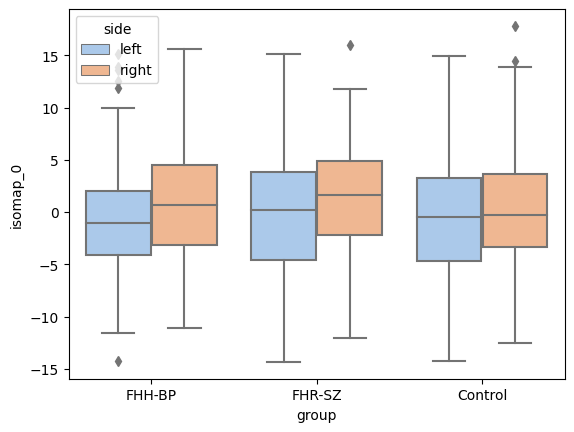

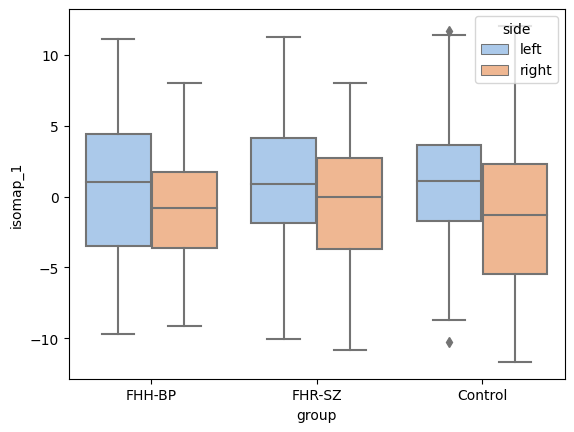

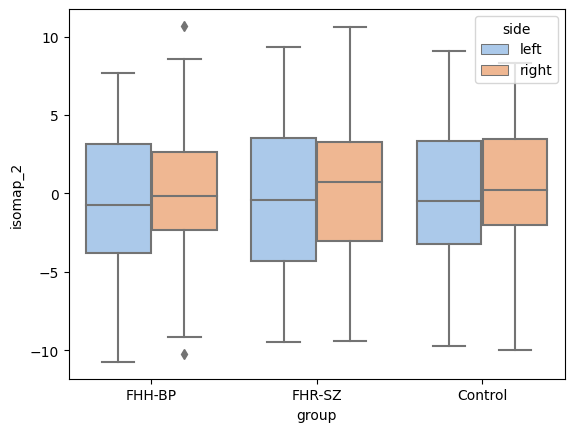

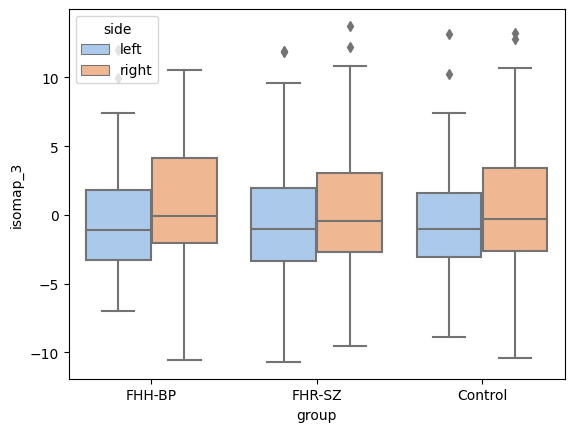

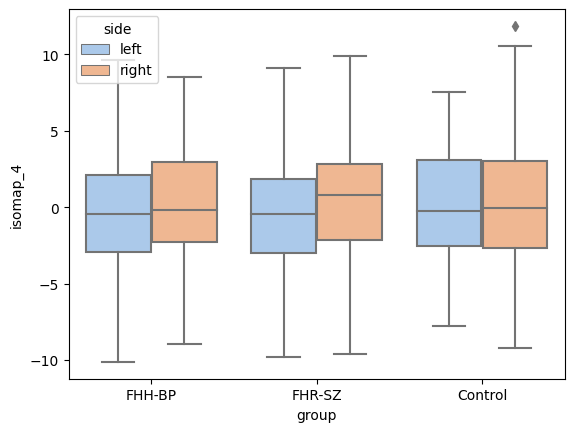

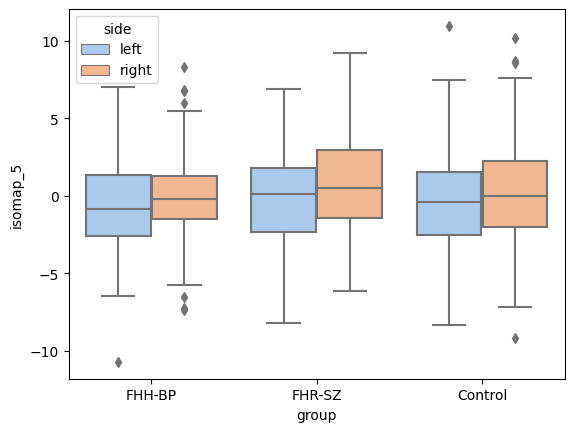

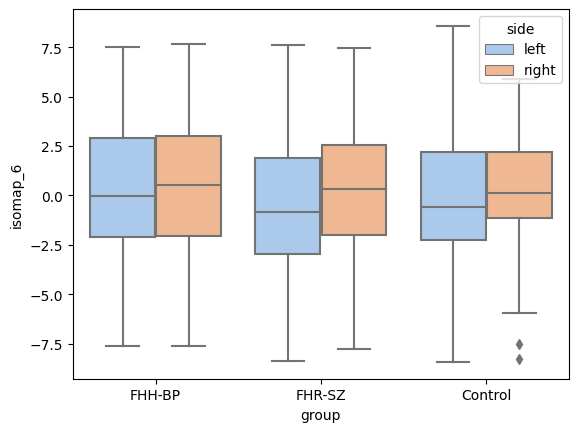

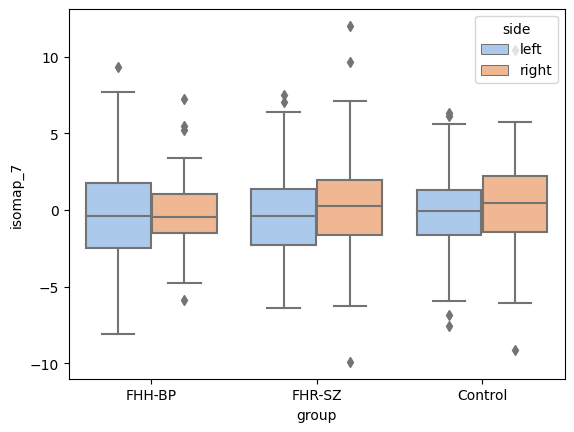

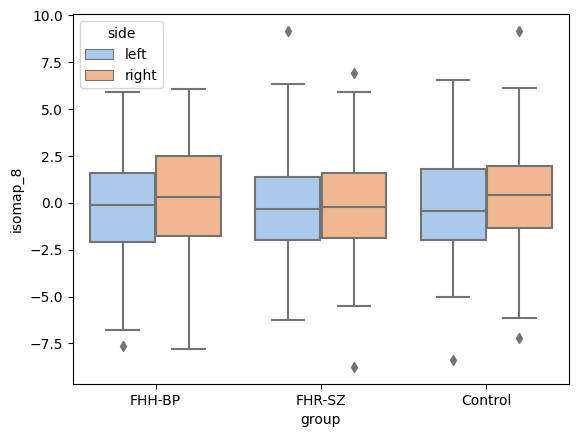

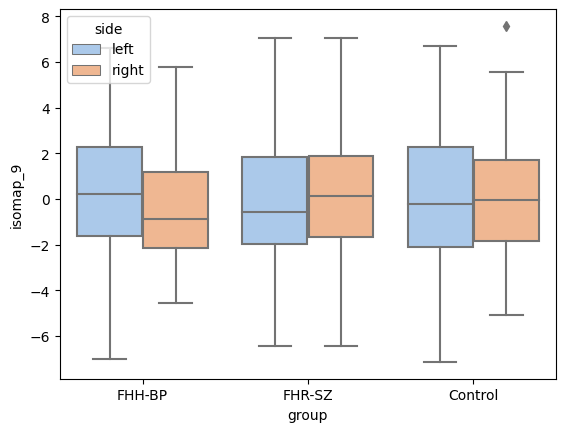

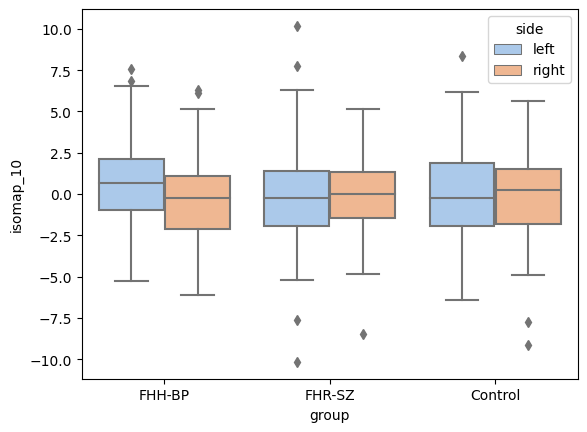

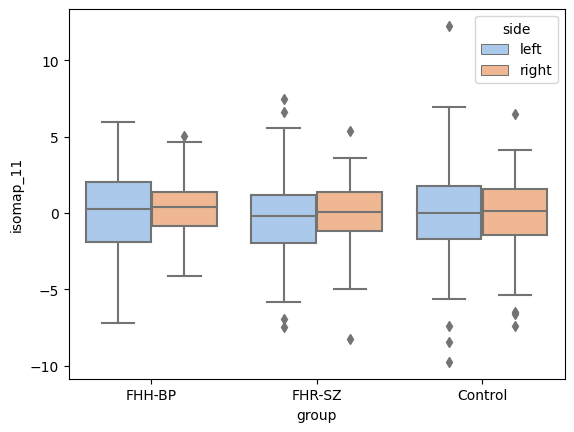

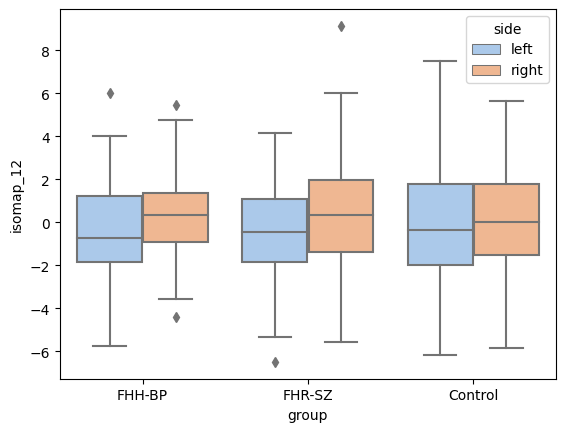

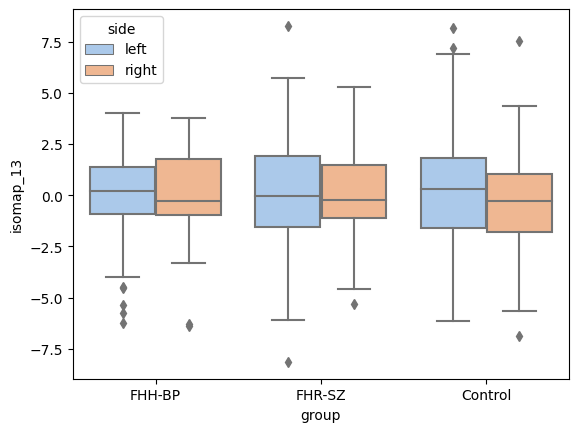

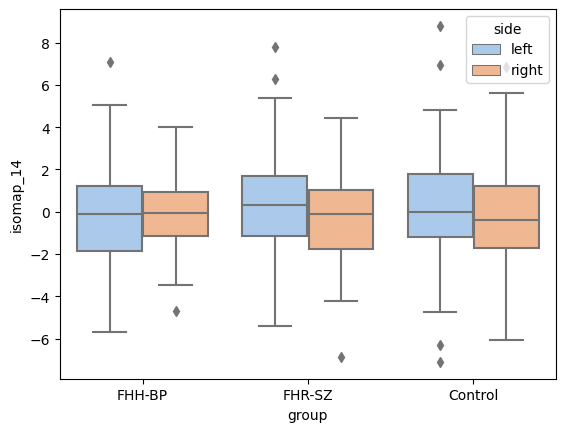

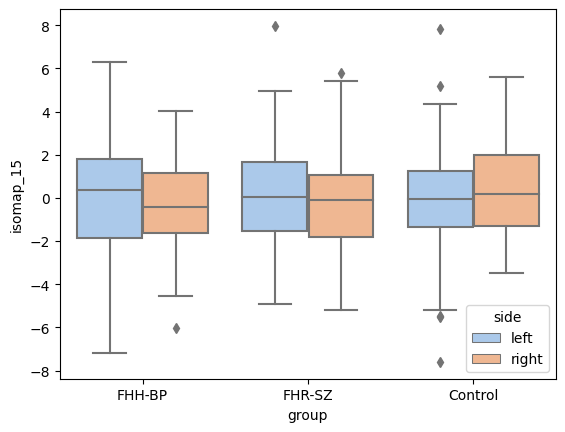

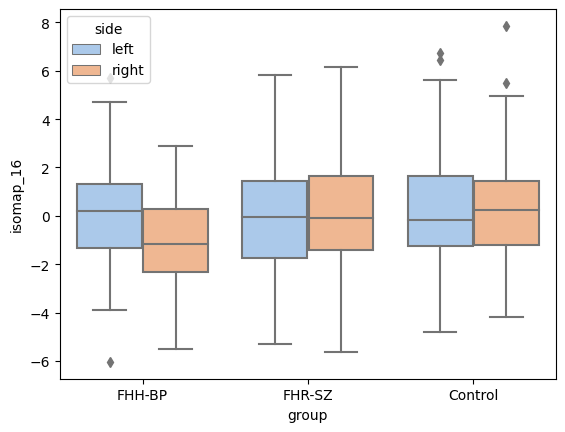

In [201]:
for id in isomap_features.columns[:-2]:
    sns.boxplot(x='group', y=id, hue='side', data=all_feat_df, palette='pastel')
    # sns.stripplot(data=all_feat_df, x='group', y='isomap_0', hue='side', palette='muted')
    plt.xticks([0, 1, 2], ['FHH-BP', 'FHR-SZ', 'Control'])
    plt.show()

In [211]:
split = StratifiedKFold(10, shuffle=True, random_state=43)
splits = split.split(all_feat_df.iloc[:, :17].values, all_feat_df.group.values)

In [214]:
for split_idx in splits:
    print(x)

(array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  20,  21,  23,  25,  26,  27,  28,  29,
        30,  31,  33,  34,  35,  36,  38,  39,  40,  41,  43,  44,  45,
        46,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155,
       156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 172,
       173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 1